In [1]:
from oemof import solph

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pyomo #necessary for the filtering components by type

In [2]:
import mpi4py
import mpisppy.utils.sputils as sputils
from mpisppy.opt.ef import ExtensiveForm

In [3]:
solver = "cbc"  # 'glpk', 'gurobi',....
debug = False  # Set number_of_timesteps to 3 to get a readable lp-file.
number_of_time_steps =  10
date_time_index = pd.date_range(
    "1/1/2012", periods=number_of_time_steps, freq="H"
)

## First some utility functions

In [74]:
def clamped_sin(x):
    return np.sin(x) if np.sin(x) > 0. else 0.

## Then define the data we work on

In [97]:
solar_data = [clamped_sin(x.hour/24. * 2. * np.pi) for x in date_time_index]
demand_data = [np.sin(x.hour/24. * 2. * np.pi) * 10 + 5 for x in date_time_index]

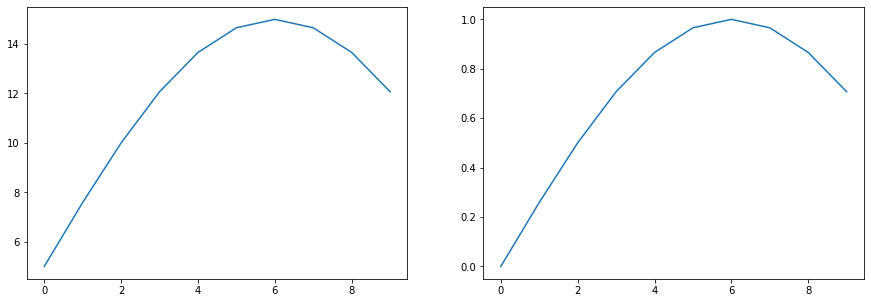

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
axes[0].plot(demand_data)
axes[1].plot(solar_data)

# Define Scenarios

In [7]:
def build_model(date_time_index, bel, gsi, gso, dem, pvi, anc_req):
    
    es = solph.EnergySystem(timeindex=date_time_index)
    es.add(bel)
    es.add(gsi)
    es.add(gso)
    es.add(dem)
    es.add(pvi)
    es.add(anc_req)
    model = solph.Model(es)
    return model

In [8]:
N_scen = 2

In [99]:
def create_scenario(scen_name):
#def create_scenario(N_scen, date_time_index, solar_data, demand_data):
    # Random demand spike at different times in each scenario
    bel = solph.Bus(label="electricity")

    gsi = solph.Sink(
            label="grid_sink",
            inputs={bel: solph.Flow(nominal_value=5000, variable_costs=0.1)},
        )

    gso = solph.Source(
            label="grid_source",
            outputs={bel: solph.Flow(nominal_value=5000, variable_costs=4)},
        )
    dem = solph.Sink(
            label="demand",
            inputs={bel: solph.Flow(fix=demand_data, nominal_value=10)},
        )

    pvi = solph.Source(
            label="pv",
            outputs={bel: solph.Flow(fix=solar_data, investment=solph.Investment(ep_costs=0.2))},
        )
    anc_req = [0. for n in range(len(demand_data))]
    pos = np.random.randint(len(demand_data) - 5)
    anc_req[pos] += 1 + np.random.randn()
    anc = solph.Sink(
            label="anc_request",
            inputs={bel: solph.Flow(fix=anc_req, nominal_value=10)},
        )
    
    model = build_model(date_time_index, bel, gsi, gso, dem, pvi, anc)
    
    scenario_independent_variables = list(filter(lambda s : 'pv' in s.to_string() and type(s) == pyomo.core.base.var._GeneralVarData, model.component_data_objects()))
    # Add first-stage cost here:
    # First-stage variables: [flow['electricity, gsi'], flow['electricity, gso'], flow['pv, electricity']]
    sputils.attach_root_node(model, [], scenario_independent_variables)

    model._mpisppy_probability = 1.0 / N_scen
    return model

In [100]:
models = []
for n in range(2):
    models.append(create_scenario(n))

In [101]:
model = create_scenario(1)

In [102]:
options = {"solver": "cbc"}
N_scen = 2
#all_scenarios = [(N_scen, date_time_index, solar_data, demand_data) for n in range(N_scen)]
all_scenarios = ["1", "2"]


ef = ExtensiveForm(options, all_scenarios, create_scenario)


[181790.38] Initializing SPBase


In [103]:
results = ef.solve_extensive_form()

objval = ef.get_objective_value()
print(f"{objval:.1f}")

401.7


In [104]:
print(results)


Problem: 
- Name: unknown
  Lower bound: 401.7441876
  Upper bound: 401.7441876
  Number of objectives: 1
  Number of constraints: 52
  Number of variables: 63
  Number of nonzeros: 37
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created subproblems: None
    Black box: 
      Number of iterations: 18
  Error rc: 0
  Time: 0.06586861610412598
Solution: 
- number of solutions: 1
  number of solutions displayed: 1
- Gap: 0.0
  Status: optimal
  Objective:
    __default_objective__:
      Value: 401.7441876
  Variable:
    ONE_VAR_CONSTANT:
      Value: 1
    x100:
      Value: 253.9058
    x101:
      Value: 207.31322
    x102:
      Value: 293.18517
    x23:
      Value: 46.592583
    x24:


In [24]:
type(list(model.component_data_objects())[-1]) 

pyomo.core.base.set.SetProduct_OrderedSet

In [31]:
l = list(filter(lambda s : 'pv' in s.to_string() and type(s) == pyomo.core.base.var._GeneralVarData, model.component_data_objects()))

In [30]:
type(l[1]) == pyomo.core.base.var._GeneralVarData

True

In [32]:
print(l)

[<pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e590>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e600>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e670>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e6e0>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e750>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e7c0>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e830>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e8a0>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e910>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90e980>, <pyomo.core.base.var._GeneralVarData object at 0x7fe4cc90ef30>]


In [65]:
results.values()

dict_values([<pyomo.opt.results.container.ListContainer object at 0x7fe4cc88cb10>, <pyomo.opt.results.container.ListContainer object at 0x7fe4cc88ca10>, <pyomo.opt.results.solution.SolutionSet object at 0x7fe4cc88cc90>])

In [110]:
soln = ef.get_root_solution()
for (var_name, var_val) in soln.items():
    print(var_name, var_val)

flow[pv,electricity,0] 0.0
flow[pv,electricity,1] 75.881905
flow[pv,electricity,2] 146.59258
flow[pv,electricity,3] 207.31322
flow[pv,electricity,4] 253.9058
flow[pv,electricity,5] 283.19512
flow[pv,electricity,6] 293.18517
flow[pv,electricity,7] 283.19512
flow[pv,electricity,8] 253.9058
flow[pv,electricity,9] 207.31322
InvestmentFlow.invest[pv,electricity] 293.18517


In [107]:
def plot_results(solution, solar_data, demand_data):
    flow = []
    pv_inv = 0.
    for (var_name, var_val) in solution.items():
        if "flow" in var_name:
            flow.append(var_val)
        elif "Investment" in var_name and "pv" in var_name:
            pv_inv = var_val
    #plt.plot(np.multiply(solar_data,pv_inv), label = "pv investement")
    plt.plot(flow, label = "pv")
    plt.plot(demand_data, label = "demand")
    plt.legend()
    plt.show()

In [80]:
list(filter("flow" in str(var_name), (var_name, var_val) in soln.items()))

TypeError: 'bool' object is not iterable

In [81]:
flow = []
for (var_name, var_val) in soln.items():
    if "flow" in var_name:
        flow.append(var_val)

In [82]:
flow

[0.0,
 11.2687,
 21.769457,
 30.786662,
 37.705806,
 42.055362,
 43.538915,
 42.055362,
 37.705806,
 30.786662]

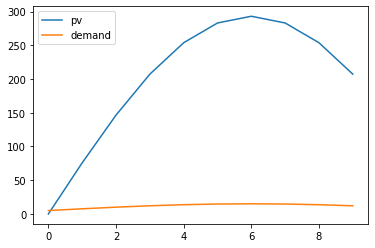

In [108]:
plot_results(soln, solar_data, demand_data)

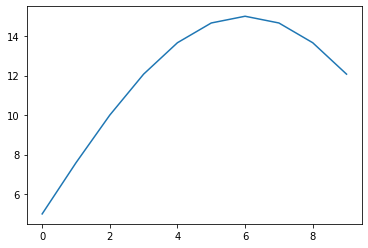

In [109]:
plt.plot(demand_data)